- Read data and transform features to appropriate format

- Explore
    - **TODO**: The banner_pos introduces position bias, maybe use SBDN estimate of position bias
    - **TODO**: There is click correlation with time of day
    - **TODO**: C1 is highly correlated with device type. they seem to be the same

- Check single and multi-variable densities
    - **TODO**: C1/Device_type highly skewed, dominates. Use multiple models
    - **TODO**: Banner position also highly skewed. Try to find better models


- **Final todo**
    - **TODO**: Replace low frequence categories with cat other. less than a 100 times will do. 
    - **TODO**: Concat features and check for the improved association
    - **TODO**: Check the assiciation of making error with skewed variables and split data accordingly.
- Implement initial model
    - one-hot
    - SGDClassifier
    - Log-loss
    - CV
    - RF

- diagnose
    - one-hot encode/Binary Encode    - 
    - chi2 selection
    - RBF kernel
    - Polynomial features
    - Remove correlations
    - PCA
    - Kernel estimation
    - CV for optimisation
    - Hyper parameter optimisation
- Iterate

# Read data

In [1]:
# Read data and explore
import pandas as pd
import numpy as np
import random
from src import categorical_association
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, log_loss, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler

from scipy import stats

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
file = "D:\OTHERFILES\Code\CTR\Azavu_train.csv"

# generate 10% random row number
## Get the row count
with open(file) as f:
    n = sum(1 for row in f)

# ## generate row index to skip
# inds = random.sample(range(1, n), int(.9 * n))

# ## read data
# data_raw = pd.read_csv(file, low_memory=True, skiprows=inds)

# ## Or simply read the initial 10/20 % 
data_raw = pd.read_csv(file, low_memory=True, nrows= int(.1*n))

# Explore data

In [70]:
# check unique values
for key in data_raw.columns:
#     clear_output()
    temp = data_raw[key].unique()
    print(key, temp)
    print(temp.shape, data_raw.shape[0])
#     if input()=='Q':
#         break

id [  1.00000942e+18   1.00001693e+19   1.00003719e+19 ...,   8.85365729e+18
   8.85410948e+17   8.85414120e+18]
(4042896,) 4042896
click [0 1]
(2,) 4042896
hour [14102100 14102101 14102102 14102103 14102104 14102105 14102106 14102107
 14102108 14102109 14102110 14102111 14102112 14102113 14102114 14102115
 14102116 14102117 14102118 14102119 14102120 14102121 14102122]
(23,) 4042896
C1 [1005 1002 1010 1001 1007 1008 1012]
(7,) 4042896
banner_pos [0 1 4 5 2 7 3]
(7,) 4042896
site_id ['1fbe01fe' 'fe8cc448' 'd6137915' ..., '6ac91893' 'aa55f77f' '8d9e19c8']
(2860,) 4042896
site_domain ['f3845767' '9166c161' 'bb1ef334' ..., 'ba57288d' '324dcd3c' '05ff0fb9']
(3372,) 4042896
site_category ['28905ebd' '0569f928' 'f028772b' '50e219e0' '3e814130' '76b2941d'
 'f66779e6' '335d28a8' '72722551' '75fa27f6' '110ab22d' 'c0dd3be3'
 'bcf865d9' 'a818d37a' '42a36e14' 'e787de0e' '5378d028' '9ccfa2ea'
 '70fb0e29' 'dedf689d' '8fd0aea4' '74073276']
(22,) 4042896
app_id ['ecad2386' '98fed791' '66a5f0f3' ..., '

C15 [ 320  300  216  728  120 1024  480  768]
(8,) 4042896
C16 [  50  250   36  480   90   20  768  320 1024]
(9,) 4042896
C17 [1722 2161 1899 2333 2374 2496 1974 2227 2371 2043  571 2434 2493 2480 1882
 2158 2271 2446 1800 1934 1863 1887 1994  423 2495 2153 2253 2264 1996  898
 1872 2036 2162  576 2312 1993 2481  572 1973 1921 2331 2449 1740 1926 1955
 2307 1092  901 1637 1784 1895  112 2351  122 2323 2424 2497 2083 2270 2295
 1248 1447 2060  196 2306 1780 2372  547  906 2283 2260 1272 2263 1752 2292
 1991 2339 2039  394 2285 2325 2427 1401 2316 1835 2154  937 2286  613  153
 2390 2284 2443 2485  544 2467 1528 1769 2303 2278  549 2465  768 2394 2478
  686 2471 2304 1698 2279 1932  178 2346 1685 2483 2476 1255 2225 2438 2425
 1884  827 2459 2397 1507 2250 2482  550 2201 2487 2229 2348 2492  761 2418
 2242 2421  479 1873 2420 2281 2206 1515 2101 1253 2218 1149 2187 1008 2282
 1965 1960 1939  832 1972 2428 1107 1174 2489 2494 1141 2084 2412  873 2181
 2479 2500 2441 1903 2436 2491 2502  

In [7]:
# check distributions
for key in data_raw.columns:
    if data_raw[key].nunique() < 50:
        clear_output()
        print(key)
        print((data_raw[key].value_counts()/data_raw[key].value_counts().sum()).sort_values()*100)
        task = input()
        if task=="Q":
            break    


site_category
110ab22d     0.000025
74073276     0.000049
9ccfa2ea     0.000173
8fd0aea4     0.001311
bcf865d9     0.001534
5378d028     0.001558
42a36e14     0.003067
e787de0e     0.008484
a818d37a     0.034357
dedf689d     0.035074
c0dd3be3     0.072695
70fb0e29     0.131119
72722551     0.195355
0569f928     0.199585
76b2941d     0.320488
75fa27f6     0.321329
335d28a8     0.462416
f66779e6     0.932426
3e814130     6.877842
28905ebd    21.842412
f028772b    28.041335
50e219e0    40.517367
Name: site_category, dtype: float64
Q


KeyboardInterrupt: 

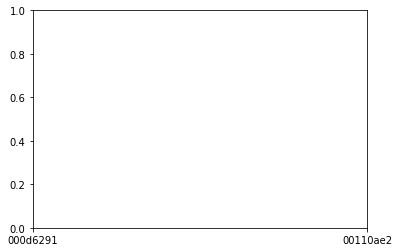

In [73]:
# check distributions
for key in data_raw.columns:
    print(key, data_raw[key].nunique())
    task = input()
    clear_output()
    if task=="p":
        data_raw[key].hist()
        plt.show()
    elif task=="Q":
        break    

In [60]:
method = "cramers_v"
cols = ['time_hour', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain','site_category', 
        'app_id', 'app_domain','app_category', 'device_type', 'device_conn_type',
        'C15', 'C16', 'C17','C18', 'C19', 'C20','C21']
temp = categorical_association(data_raw.loc[:,cols], method)

C21 C21


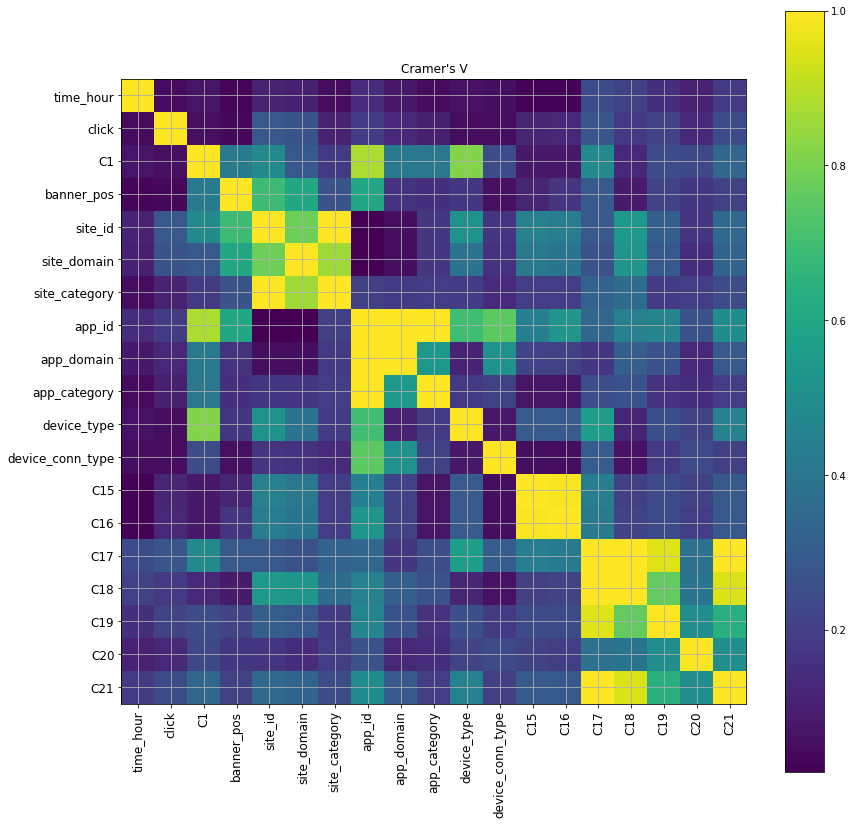

In [61]:
from matplotlib import cm as cm

fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('viridis')
cax = ax1.imshow(temp, interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title("Cramer's V")
labels=cols#[col for col in data_raw.columns]
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,fontsize=12,rotation='vertical')
ax1.set_yticks(np.arange(len(labels)))
ax1.set_yticklabels(labels,fontsize=12)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax)
plt.savefig("cramer.png")
plt.show()

In [79]:
data_raw["time_hour"] = data_raw.hour.map(lambda x: x%100).astype("int")
# convert to categories
for key in data_raw.columns:
    if key not in ["hour", ]:
        data_raw[key] = data_raw[key].astype("category").cat.codes

# First try

- Linear model 
- hand feature selection 
- one-hot encoding

### Model

In [95]:
print(data.columns)
data.click.mean()

Index(['C1', 'banner_pos', 'site_category', 'app_category', 'device_type',
       'device_conn_type', 'C15', 'C18', 'click'],
      dtype='object')


0.17393769218896554

In [159]:
# Implement initial model
# subset columns for one-hot encoding
cols = ['C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type',
        'C15','C18', 
        'click']
data = data_raw.loc[:, cols].copy()

# Train test split 80 t0 20

sample_size = data.shape[0]
train = data.iloc[:int(np.floor(sample_size*.8)),:].copy()
# validation = data.iloc[int(np.floor(sample_size*.6)):int(np.floor(sample_size*.8)),:].copy()
test = data.iloc[int(np.floor(sample_size*.8)): ,:].copy()

# Shuffle train data
train = shuffle(train)

x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
# x_val = validation.iloc[:, :-1]
# y_val = validation.iloc[:, -1]
x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

# One-Hot encode
enc = OneHotEncoder()
x_train = enc.fit_transform(x_train)
x_test = enc.transform(x_test)

In [132]:
# Logisic Regression with log_loss
clf = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=1)

param_dist = {"alpha":  np.logspace(-7, 0, 1e4),
              "l1_ratio": np.linspace(0, 1, 1e5)
             }

# run randomized search
log_score = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
            
n_iter_search = 48
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_jobs=4,
                                   scoring = log_score, n_iter=n_iter_search)

random_search.fit(X=x_train, y=y_train);

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
d:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [133]:
# diagnostics: log_loss, error matrix, probability of error by different categories
preds = random_search.predict(X=x_test)
# Confusion matrix
confusion_matrix(preds, y_test), f1_score(preds, y_test), log_loss(preds, y_test), np.mean(preds)

(array([[663964, 143925],
        [   389,    302]], dtype=int64),
 0.0041678742461253955,
 6.164565112561875,
 0.00085458458037547308)

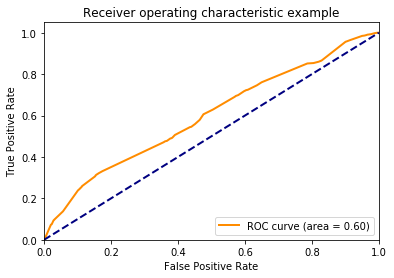

In [134]:
# ROC
y_score = random_search.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Second try

- select top 95% of categories for each feature
- Linear model
- One-hot-all features 

In [197]:
# Select test train data
data = data_raw.copy()
data.drop(['id', 'hour', 'device_ip'], axis=1, inplace=True)

# remove low freq categories
for col in data.columns:
    temp = data[col].value_counts()
    ind = (data[col].value_counts()/data[col].value_counts().sum())<.05
    temp[ind] = max(temp.index) + 1
    temp[~ind] = temp[~ind].index
    temp
    data[col] = data[col].map(temp)

# Train test split 80 t0 20
sample_size = data.shape[0]
train = data.iloc[:int(np.floor(sample_size*.8)),:].copy()
test = data.iloc[int(np.floor(sample_size*.8)): ,:].copy()

# Shuffle train data
train = shuffle(train)

x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [198]:
# One-Hot encode
enc = OneHotEncoder()
x_train = enc.fit_transform(x_train)
x_test = enc.transform(x_test)

In [200]:
# Logisic Regression with log_loss
clf = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=1)

param_dist = {"alpha":  np.logspace(-7, 0, 1e4),
              "l1_ratio": np.linspace(0, 1, 1e5)
             }

# run randomized search
log_score = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
            
n_iter_search = 24
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_jobs=4,
                                   scoring = log_score, n_iter=n_iter_search)

random_search.fit(X=x_train, y=y_train);

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
d:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [201]:
# diagnostics: log_loss, error matrix, probability of error by different categories
preds = random_search.predict(X=x_test)
# Confusion matrix
confusion_matrix(preds, y_test), f1_score(preds, y_test), log_loss(preds, y_test), np.mean(preds)

(array([[662478, 142738],
        [  1875,   1489]], dtype=int64),
 0.020177382089693819,
 6.1773358279146331,
 0.0041603799253011452)

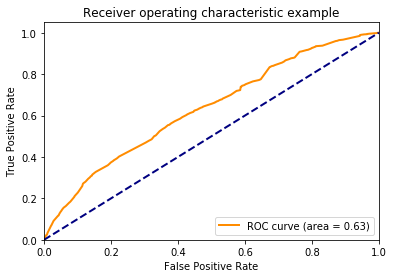

In [202]:
# ROC
y_score = random_search.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Third try
- 95% categories
- One hot encoding
- choose 10 features
- Use RBF kernel
- Linear regression

In [204]:
# Select test train data
data = data_raw.copy()
data.drop(['id', 'hour', 'device_ip'], axis=1, inplace=True)

# remove low freq categories
for col in data.columns:
    temp = data[col].value_counts()
    ind = (data[col].value_counts()/data[col].value_counts().sum())<.05
    temp[ind] = max(temp.index) + 1
    temp[~ind] = temp[~ind].index
    temp
    data[col] = data[col].map(temp)

# Train test split 80 t0 20
sample_size = data.shape[0]
train = data.iloc[:int(np.floor(sample_size*.8)),:].copy()
test = data.iloc[int(np.floor(sample_size*.8)): ,:].copy()

# Shuffle train data
train = shuffle(train)

x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [205]:
# One-Hot encode
enc = OneHotEncoder()
x_train = enc.fit_transform(x_train)
x_test = enc.transform(x_test)

# select features
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(chi2, k=10)
x_train = selector.fit_transform(x_train, y_train)
x_test = selector.transform(x_test)

In [218]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
# Logisic Regression with log_loss
clf = SGDClassifier(loss='log', penalty='elasticnet', n_jobs = -1)

param_dist = {"clf__alpha":  np.logspace(-7, 0, 1e2),
              "clf__l1_ratio":  np.linspace(0, 1, 1e4),
              "rbf_estimate__gamma": np.logspace(-9, 3, 100)
             }

estimators = [('rbf_estimate', rbf_feature), ('clf', clf)]
pipe = Pipeline(estimators)


# run randomized search
log_score = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
            
n_iter_search = 12
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_jobs=4,
                                   scoring = log_score, n_iter=n_iter_search)

random_search.fit(X=x_train, y=y_train);

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
d:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [222]:
# diagnostics: log_loss, error matrix, probability of error by different categories
preds = random_search.predict(X=x_test)
# Confusion matrixb
np.mean(preds)

0.0

### All Zero Prediction

# Forth try
- Add new features
- 97% categories
- one-hot
- Linear regression

In [242]:
# Select test train data
data = data_raw.copy()
data.drop(['id', 'hour', 'device_ip'], axis=1, inplace=True)

# remove low freq categories
for col in data.columns:
    temp = data[col].value_counts()
    ind = (data[col].value_counts()/data[col].value_counts().sum())<.03
    temp[ind] = max(temp.index) + 1
    temp[~ind] = temp[~ind].index
    temp
    data[col] = data[col].map(temp)

In [243]:
# combine features
cols = [('banner_pos', 'site_category'),
        ('banner_pos', 'app_category'),
        ('banner_pos', 'device_type'),
        ('banner_pos', 'C16'),
        ('banner_pos', 'C18'),
        ('site_category', 'app_category'),
        ('site_category', 'device_type'),
        ('site_category', 'C16'),
        ('site_category', 'C18'),
        ('app_category', 'device_type'),
        ('app_category', 'C16'),
        ('app_category', 'C18'),
        ('device_type', 'C16'),
        ('device_type', 'C18'),
        ('C16', 'C18'),
       ]

for i, j in cols:
    print(i, j)
    data[str(i)+'_'+str(j)] = data.loc[:, (i, j)].apply(lambda x: str(x[0])+str(x[1]) , axis=1)

banner_pos site_category
banner_pos app_category
banner_pos device_type
banner_pos C16
banner_pos C18
site_category app_category
site_category device_type
site_category C16
site_category C18
app_category device_type
app_category C16
app_category C18
device_type C16
device_type C18
C16 C18


In [246]:
# Train test split 80 t0 20
sample_size = data.shape[0]
train = data.iloc[:int(np.floor(sample_size*.8)),:].copy()
test = data.iloc[int(np.floor(sample_size*.8)): ,:].copy()

# Shuffle train data
train = shuffle(train)

x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [249]:
# One-Hot encode
enc = OneHotEncoder()
x_train = enc.fit_transform(x_train)
x_test = enc.transform(x_test)

# # select features
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest
# selector = SelectKBest(chi2, k=100)
# x_train = selector.fit_transform(x_train, y_train)
# x_test = selector.transform(x_test)

In [261]:
# Logisic Regression with log_loss
clf = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=1)

param_dist = {"alpha":  np.logspace(-7, 0, 1e4),
              "l1_ratio": np.linspace(0, 1, 1e5)
             }

# run randomized search
log_score = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
            
n_iter_search = 16
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_jobs=4,
                                   scoring = log_score, n_iter=n_iter_search)

random_search.fit(X=x_train, y=y_train);

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
d:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [253]:
# diagnostics: log_loss, error matrix, probability of error by different categories
preds = random_search.predict(X=x_test)
# Confusion matrix
confusion_matrix(preds, y_test), f1_score(preds, y_test), log_loss(preds, y_test), np.mean(preds)

(array([[658736, 138916],
        [  5617,   5311]], dtype=int64),
 0.068460571686378133,
 6.173914820502902,
 0.013515051077197061)

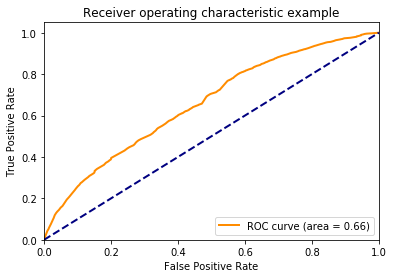

In [254]:
# ROC
y_score = random_search.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Fifth try

- Encode categories

In [242]:
# Select test train data
data = data_raw.copy()
data.drop(['id', 'hour', 'device_ip'], axis=1, inplace=True)

# remove low freq categories
for col in data.columns:
    temp = data[col].value_counts()
    ind = (data[col].value_counts()/data[col].value_counts().sum())<.03
    temp[ind] = max(temp.index) + 1
    temp[~ind] = temp[~ind].index
    temp
    data[col] = data[col].map(temp)

In [243]:
# combine features
cols = [('banner_pos', 'site_category'),
        ('banner_pos', 'app_category'),
        ('banner_pos', 'device_type'),
        ('banner_pos', 'C16'),
        ('banner_pos', 'C18'),
        ('site_category', 'app_category'),
        ('site_category', 'device_type'),
        ('site_category', 'C16'),
        ('site_category', 'C18'),
        ('app_category', 'device_type'),
        ('app_category', 'C16'),
        ('app_category', 'C18'),
        ('device_type', 'C16'),
        ('device_type', 'C18'),
        ('C16', 'C18'),
       ]

for i, j in cols:
    print(i, j)
    data[str(i)+'_'+str(j)] = data.loc[:, (i, j)].apply(lambda x: str(x[0])+str(x[1]) , axis=1)

banner_pos site_category
banner_pos app_category
banner_pos device_type
banner_pos C16
banner_pos C18
site_category app_category
site_category device_type
site_category C16
site_category C18
app_category device_type
app_category C16
app_category C18
device_type C16
device_type C18
C16 C18


In [300]:
# encode to continous
newdata = data.copy()
for col in newdata.columns:
    if col not in ['click']:
        clear_output()
        print(col)
        temp = pd.pivot_table(newdata, index=[col], values='click', aggfunc='mean')
        newdata[col] = newdata[col].map(temp.squeeze())    

C16_C18


In [302]:
# Train test split 80 t0 20
sample_size = newdata.shape[0]
train = newdata.iloc[:int(np.floor(sample_size*.8)),:].copy()
test = newdata.iloc[int(np.floor(sample_size*.8)): ,:].copy()

# Shuffle train data
train = shuffle(train)

x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [307]:
# Logisic Regression with log_loss
clf = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=1)

param_dist = {"alpha":  np.logspace(-4, 0, 20),
              "l1_ratio": np.linspace(0, 1, 20)
             }

# run randomized search
log_score = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
            
n_iter_search = 16
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_jobs=4,
                                   scoring = log_score, n_iter=n_iter_search)

random_search.fit(X=x_train, y=y_train);

d:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [308]:
# diagnostics: log_loss, error matrix, probability of error by different categories
preds = random_search.predict(X=x_test)
# Confusion matrix
confusion_matrix(preds, y_test), f1_score(preds, y_test), log_loss(preds, y_test), np.mean(preds)

(array([[651455, 134544],
        [ 12898,   9683]], dtype=int64),
 0.11609754927821209,
 6.2981694455156818,
 0.027926735758984886)

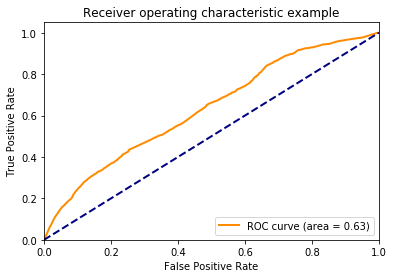

In [310]:
# ROC
y_score = random_search.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
# Logisic Regression with log_loss
clf = SGDClassifier(loss='log', penalty='l2', n_jobs = -1)

param_dist = {"clf__alpha":  np.logspace(-4, 0, 30),
#               "clf__l1_ratio":  np.linspace(0, 1, 20),
              "pca__whiten": [True, False],
              'pca__n_components': [5, 10, 15, 20],
             }

estimators = [('pca', PCA()), ('clf', clf)]
pipe = Pipeline(estimators)


# run randomized search
# log_score = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
            
n_iter_search = 8
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_jobs=4,
#                                    scoring = log_score,
                                   n_iter=n_iter_search)

random_search.fit(X=x_train, y=y_train);

d:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [ ]:
# diagnostics: log_loss, error matrix, probability of error by different categories
preds = random_search.predict(X=x_test)
# Confusion matrix
confusion_matrix(preds, y_test), f1_score(preds, y_test), log_loss(preds, y_test), np.mean(preds)

In [ ]:
# ROC
y_score = random_search.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()